# 1. Learning Objectives

The objective of this lab assignment is that you should get hands-on experience with implementing and using a support vector machine from scratch. In particular, you should be able to:

* Use the mathematical formulation of the optimization task,
* Formulate the indicator function and explain how it relates to the outcome of the classification,
* Predict and explain the outcome of using different kernels,
* Explain the effect of the C-value when using slack variables.

In addition, you will gain some experience in using Python together with the packages numpy, scipy, and matplotlib, commonly used for scientific computing.

# 2. Theory

The idea is to build a classifier which first makes an transformation of the input data, and then a linear separation where the decision boundary is placed to give maximal margins to the available data points. The location of the decision boundary is given by the weights ($\vec{w}$) and the bias (b) so the problem is to find the values for ($\vec{w}$) and b which maximize the margin, i.e. the distance to any datapoint.

## 2.1. Dual Formulation

Given a constrained optimization problem, known as the primal problem, it is possible to express a different but closely related problem, called its dual problem, as shown in equation 5-3 of the book.

Find the values $\alpha^{(i)}$ which minimize:
\begin{align}
\frac{1}{2} \sum_{i=1}^m  \sum_{j=1}^m \alpha^{(i)}  \alpha^{(j)} t^{(i)} t^{(j)} {x^{(i)}}^T x^{(j)} -  \sum_{i=1}^m \alpha^{(i)}
\end{align}

subject to the constraints $\alpha^{(i)} \geqslant 0$ for $ i = 1,2,...,m$  and  $\sum_{i}   \alpha^{(i)} t^{(i)} = 0$

where we have the following notation:

* $\vec{w}$ is the weight vector defining the separating hyperplane
* $b$ is the offset (bias) for the hyperplane
* ${x}_i$ is the $i^{th}$ data point
* $t_i$ is the target class (-1 or 1) for datapoint i

Once you find the vector $\hat{\alpha}$ that minimizes this equation (using a QP solver), you can compute $\hat{w}$ and $\hat{b}$ that minimize the primal problem by using the primal solution shown in equation 5-4 of the book.

\begin{align}
\hat{w} = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} x^{(i)}
\end{align}
\begin{align}
\hat{b} = \frac{1}{n_{s}} \sum_{i=1}^m (t^{(i)} - {\hat{w}}^T x^{(i)})
\end{align}

## 2.2. Adding Slack Variables

Instead of requiring that every datapoint is outside the margin we will allow for mistakes, quantified by variables $ \zeta ^{i}$ (positive values; one for each datapoint). These are called slack variables. The constraints will now be

\begin{align}
\text{minimize}_{w,b,\zeta} \frac{1}{2} {w}^T w + C \sum_{i=1}^m  \zeta ^{i}
\end{align}
subject to 
\begin{align}
t^{(i)}(w^T x^{(i)} + b) \geqslant 1 - \zeta ^{i} \\ \text{  and  } \zeta ^{i} \geqslant 0 \text{  for i = 1,2,...,m}
\end{align}

## 2.3. Kernel Functions

In Machine Learning, a kernel is a function capable of computing the dot product based only on the original vectors a and b, without having to know about the transformation. The function $K(\vec{x}_i , \vec{x}_j)$ is called a kernel function and computes the scalar value corresponding to $\phi{(x_i)}· \phi{(x_j)}$. This is, however, normally done implicitly, i.e., without actually computing the two vectors and taking their scalar product

Below are some of the most commonly used kernels.

Linear: $ K(a,b) = {a}^T b$

Polynomial: $ K(a,b) = {({a}^T b + r)}^d $

Gaussian RBF: $ K(a,b) = exp(-\gamma {|| a - b ||}^2) $

With the addition of the kernel function, we can rewrite the dual formulation equation from section 2.1 as:

Find the values $\alpha^{(i)}$ which minimize:
\begin{align}
\frac{1}{2} \sum_{i=1}^m  \sum_{j=1}^m \alpha^{(i)}  \alpha^{(j)} t^{(i)} t^{(j)} K(\vec{x}_i , \vec{x}_j) -  \sum_{i=1}^m \alpha^{(i)}
\end{align}


# 3. Implementation

We will use the general purpose optimization function minimize available in the scipy.optimize library as our QP solver. This will work well for the small problems we are dealing with here. For more complex problems, perhaps with thousands of samples, it is better to use one of the special purpose optimizers like LIBSVM developed to be efficient specifically for SVM.

Start by importing minimize from scipy.optimize, along with the other packages you will need:


In [2]:
import numpy as np
import random, math
from scipy.optimize import minimize ## This is your QP solver
import matplotlib.pyplot as plt

The heart of your program will be a single call to the minimize function. A call to minimize should look like this pseudocode:
```
min_ = minimize(objective, alpha_0, bounds = B, constraints = XC)
alpha = min_.x
```
This will find the vector $\vec{\alpha}$ which minimizes the function objective within the bounds B and the constraints XC.

```objective``` is a function you have to define, which takes a vector $\vec{\alpha}$ as argument and returns a scalar value, effectively implementing the expression that should be minimized, in our case the dual formulation equation shown in section 2.1.

```alpha_0``` is a vector with the initial guess of the $\vec{\alpha}$ vector. We can, e.g., simply use a vector of zeros: numpy.zeros(N). N is here the number of training samples (note that each training sample will have a corresponding ${\alpha}$-value).

B is a list of pairs of the same length as the $\vec{\alpha}$ -vector, stating the lower and upper bounds for the corresponding element in $\vec{\alpha}$. To constrain the ${\alpha}$ values to be in the range 0 ≤ ${\alpha}$ ≤ C, we can set ```bounds=[(0, C) for b in range(N)]```. To only have a lower bound, set the upper bound to ```None``` like this: ```bounds=[(0, None) for b in range(N)].```


## 3.1 Generate test data

To test your support vector machine, you will also need code for generating test data and for visualizing the results. In the following sections you will be given code fragments that you can use directly in your program to achieve this. __You will later need to move the clusters around and change their spread by changing the values in this code sample.__

Hint: If you insert a call ```“numpy.random.seed(100)”``` before the code that generates the data, you will get the same random data every time you run the program. This can help during debugging.

In [3]:
# Create dataset
classA = np.random.randn(100, 2) * 0.3 + [1.5,0.5]
classB = np.random.randn(200, 2) * 0.3 + [0.0, 0.0]

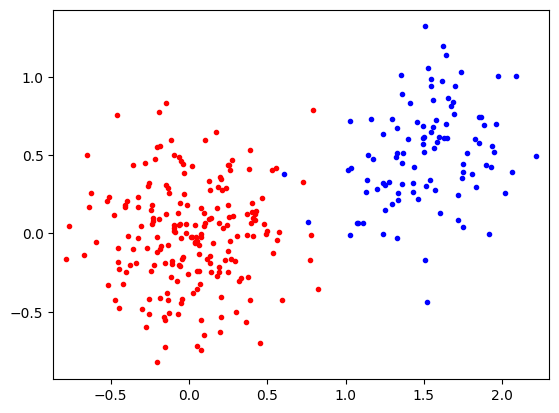

In [4]:
# Let us see how our dataset looks
plt.plot( [ p[0] for p in classA], [ p[1] for p in classA], 'b. ' )
plt.plot( [ p[0] for p in classB], [ p[1] for p in classB], 'r. ' )

xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-3, 3)

plt.axis('equal')           # Force same scale on both axes
plt .show()                 # Show the plot on the screen

In [5]:
# Create vectors with inputs and targets
inputs = np.concatenate((classA , classB))  # x and y coordinates for the data
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))  # holds the +1 or -1 values for the inputs, their indices in the list coincide respectively

n_train = inputs.shape[0]  # Number of samples

#The last four lines randomly reorder the samples. 
permute = list(range(n_train))
random.shuffle(permute)
inputs = inputs[permute, : ]  # Training values
targets = targets[permute]    # Training labels

## 3.2. For you to implement

You will have to write code for:

### 3.2.1 A suitable kernel function:
  
The kernel function takes two data points as arguments and returns a “scalar product-like” similarity measure; a scalar value. Start with the linear kernel which is the same as an ordinary scalar product, but also explore the other kernels in section 2.3. Create a function for each kernel


In [8]:
# Hint: Let gamma and r in the polynomial be 1

degree = 2 #hyperparameter for polynomial kernel
gamma = 1 #hyperparameter for rbf kernel

def linearKernel(x, y):
    return ## TO DO ##

def polyKernel(x, y, degree, r=1):
    return ## TO DO ##

def rbfKernel(x, y, gamma):
    return ## TO DO ##

# Set which kernel you want to use
kernel = linearKernel

### 3.2.2 Implement the function objective

Define a function which implements the dual formulation equation shown in section 2.1. This function will only receive the vector $\vec{\alpha}$ as a parameter. You can use global variables for other things that the function needs (t and K values).

Python hint: This function will be called hundreds of times, so it makes sense to care about efficiency.

You can pre-compute a matrix with these values:
\begin{align}
P_{i,j} = t_{i}t_{j}K(x_i,x_j)
\end{align}

In [ ]:
# Function to calculate P matrix

def __compute_P_mat(t, x, kernel):
        P = np.zeros((len(x), len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                P[i][j] = ## TO DO ##
        return P

Indices i and j run over all the data points. Thus, if you have N data points, P should be an N × N matrix. This matrix should be computed only once, outside of the function objective. Therefore, store it as a numpy array in a global variable.
Inside the ```objective``` function, you can now make use of the functions ```numpy.dot``` (for vector-vector, vector-matrix, and matrix-vector multiplications), and numpy.sum (for summing the elements of a vector). This is much faster than explicit for-loops in Python.


In [9]:
# Objective function which we want to minimize

def __objective(alpha):
        return ## TO DO ##


### 3.2.3 Implement the function zerofun
This function should implement the equality constraint in section 2.1. Also here, you can make use of numpy.dot to be efficient.


In [213]:
def __zerofun(alpha):
        return np.dot(np.transpose(alpha), targets)

### 3.2.4 Call minimize
Make the call to minimize as indicated in the code sample given in the introduction of section 3. Note that minimize returns a dictionary data structure; this is why we must must use the string 'x' as an index to pick out the actual ${\alpha}$ values. There are other useful indices that you can use; in particular, the index 'success' holds a boolean value which is True if the optimizer actually found a solution.


In [ ]:
## Set your slack variable C
C = 100

## Compute the P matrix
P = __compute_P_mat(targets, inputs, kernel = linearKernel)
alpha_0 = np.zeros(n_train)
bounds = [(0, C) for b in range(n_train)]
constraint = {'type':'eq', 'fun':__zerofun}

__min = minimize(__objective, alpha_0, bounds = bounds, constraints = constraint)

# use the string 'x' as an index to pick out the actual alpha values
alpha = __min.x

# see if the optimizer found a solution
if __min.success:
    print("Success")
else:
    print("ERROR: Optimization didnt converge")


### 3.2.5 Extract the non-zero α values

If the data is well separated, only a few of the α values will be non-zero. Since we are dealing with floating point values, however, those that are supposed to be zero will in reality only be approximately zero. Therefore, use a low threshold (10−5 should work fine) to determine which are to be regarded as non-zero.

You need to save the non-zero αi’s along with the corresponding data points (xi) and target values (ti) in a separate data structure, for instance a list.

In [215]:
epsilon = 1e-5

non_zero_vals = []
for i in range(len(alpha)):
    if alpha[i] > epsilon:
        non_zero_vals.append((alpha[i], inputs[i], targets[i]))


### 3.2.6 Calculate the b value
Note that you must use a point on the margin. This corresponds to a
point with an α-value larger than zero, but less than C (if slack is used). To compute the b value we need to use equation 5-12 from the book:
\begin{align}
\hat{b} = \frac{1}{n_s} \sum_{i=1}^m \left( t^{i} - \sum_{j=1}^m \hat{\alpha}^{(j)} t^{(j)} K(x^{(i)},x^{(j)}) \right)
\end{align}

In [216]:
def __compute_b():
    support_vector = non_zero_vals[0][1]
    t_support = non_zero_vals[0][2]
    
    for alpha, x, t in non_zero_vals:
        if alpha < C:
            t_support = t
            support_vector = x

    if t_support == 0:
        print("ERROR: Couldn't find alpha < C")
        return 0

    b_result = 0
    for alpha, x, t in non_zero_vals:
        b_result += alpha*t*kernel(support_vector, x)
    return b_result - t_support

b = __compute_b()

### 3.2.7 Implement the indicator function
Implement the indicator function which uses the non-zero $\alpha_{i}$’s together with their xi’s and ti’s to classify new points. This corresponds to equation 5-11 from the book:

\begin{align}
h_{\hat{w},\hat{b}}(\phi (x^{(n)})) = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} K(x^{(i)},x^{(n)}) - \hat{b}
\end{align}
where 
$\hat{\alpha}^{(i)} > 0$
 


In [10]:
def indicator(point):

    ## TO DO ##
    
    return sumation - b

# 4. Plotting

In order to see your data, you can use the plot functions from matplotlib. This code will plot your two classes using blue and red dots.

## 4.1. Plotting the decision boundary

In [6]:
def plot(classA, classB):
        plt.plot( [ p[0] for p in classA], [ p[1] for p in classA], 'b. ' )
        plt.plot( [ p[0] for p in classB], [ p[1] for p in classB], 'r. ' )

        xgrid = np.linspace(-5, 5)
        ygrid = np.linspace(-3, 3)
        grid = np.array([[indicator(np.array((x,y)))
                            for x in xgrid]
                            for y in ygrid])

        plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0),
                    colors = ("red", "black", "blue"),
                    linewidths = (1, 3, 1))
        plt.title(kernel)
        plt.axis('equal')           # Force same scale on both axes
        plt.savefig('svmplot.png')  # Save a copy in a file
        plt .show()                 # Show the plot on the screen


In [ ]:
plot(classA, classB)

# 5. Exploring and Reporting

## 5.1 Exploring with linear kernel
(1) Move the clusters in the given dataset around and change their sizes to make it easier or harder for the linear classifier to find a good boundary (for example by overlapping the dataset). Illustrate your answer using labelled plots.

(2) Describe whether the optimizer fails to converge in some cases and why. Illustrate your answer using labelled plots.

## 5.2 Testing non-linear kernels
Once you have the linear kernel up and running, you can explore a dataset that is not linearly separable.

(1) Try to use a polynomial kernel to classify the dataset below.

(2) Try to use an rbf kernel to classify the dataset below. Below is an example of how the RBF kernel could look.

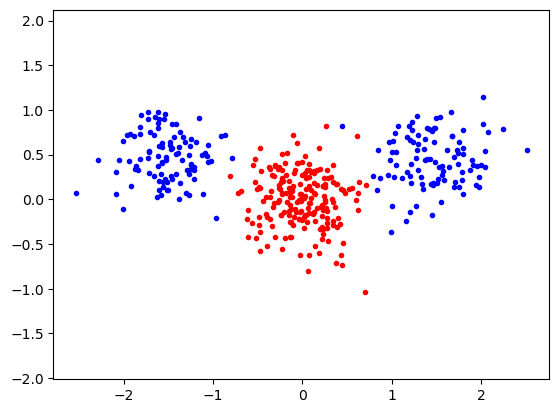

In [221]:
# Non-linearly separable
# Create dataset
classA = np.concatenate((\
        np.random.randn(100, 2) * 0.3 + [1.5,0.5],\
        np.random.randn(100, 2) * 0.3 + [-1.5,0.5]))
classB = np.random.randn(200, 2) * 0.3 + [0.0, 0.0]

plt.plot( [ p[0] for p in classA], [ p[1] for p in classA], 'b. ' )
plt.plot( [ p[0] for p in classB], [ p[1] for p in classB], 'r. ' )

xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-3, 3)

plt.axis('equal')           # Force same scale on both axes
plt .show()                 # Show the plot on the screen

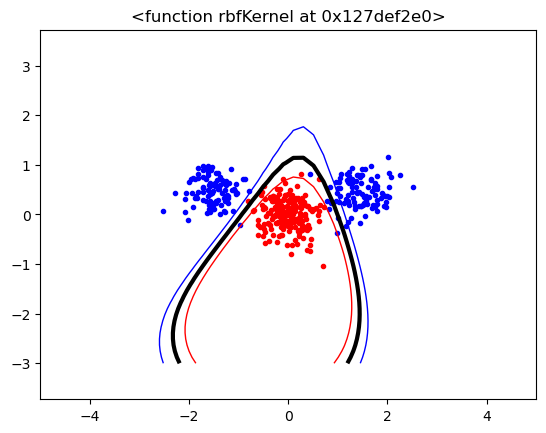

In [222]:
# Create vectors with inputs and targets
inputs = np.concatenate((classA , classB))  # x and y coordinates for the data
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))  # holds the +1 or -1 values for the inputs, their indices in the list coincide respectively

n_train = inputs.shape[0]  # Number of samples

permute = list(range(n_train))
random.shuffle(permute)
inputs = inputs[permute, : ]  # Training values
targets = targets[permute]    # Training labels

plot(classA, classB)

## 5.3 Kernel parameters

(1) Explore how the degree parameter of the polynomial kernel influences the decision boundary. Reason about this in terms of the bias variance trade-off. Explain using plots.

(2) Explore how the gamma parameter of the RBF kernel influences the decision boundary. Reason about this in terms of the bias variance trade-off. Explain using plots.

## 5.4 Slack parameter
Explore the role of the slack parameter C for the various kernels. What happens for very large/small values? Illustrate your answer with plots.

## 5.5 Sklearn SVM
Sklearn have a package for implementing SVMs. Apply this model to the generated data - how does the RBF kernel compare with the ones you have created? Explain using plots. Hint: You can make use of the model.decision function to plot the decision boundary.

In [ ]:
from sklearn import svm

SVC = svm.SVC(kernel = 'rbf', C=1, gamma = 1)
SVC.fit(inputs, targets)